In [27]:
import csv
from collections import defaultdict, Counter
import re
import unicodedata
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

punct_chars = list(set(string.punctuation) | {'’', '‘', '–', '—', '~', '|', '“', '”', '…', "'", "`", '_'})
punct_chars.sort()
punctuation = ''.join(punct_chars)
replace = re.compile('[%s]' % re.escape(punctuation))

# Racial and Ethnic Representation in Literature Taught in US High Schools

This notebook shows how to use our data to reproduce key figures from our paper. 

In [17]:
def get_last_name(author_input, filter_multiple=True, last_name_first=False):
    if type(author_input) == str: 
        name = author_input
    else: 
        print("PROBLEM!")
    name = name.lower()
    name = name.replace(".", " ")
    name = name.replace(", jr", "")
    name = name.replace(", sr", "")
    name = name.replace(", ph d ", "")
    name = re.sub(r'\([^)]*\)', '', name) # remove parenthesis
    name = ''.join(c for c in unicodedata.normalize('NFD', name)
                  if unicodedata.category(c) != 'Mn') # strip accents 
    if ":" in name:
        name = name.split(":")[1]
    name = name.strip()
    
    # Filter books with multiple authors
    if filter_multiple: 
        if type(author_input) == str and not last_name_first and name.count(",") > 0: 
            return None
        if name.count(",") > 1 or ("&" in name) or (" and " in name) or (";" in name) or (not last_name_first and (name.count(",") > 0)):
            return None
    
    if last_name_first:
        last_name = name.split(",")[0]
    else:
        name = name.split(",")[0]
        last_name = name.split(" ")[-1]
    return last_name.strip()

def clean_title(title):
    title = title.lower().strip()
    if title.endswith(", the"):
        title = title[:-5]
    if title.endswith(", a"):
        title = title[:-3]
    if title.endswith(", an"):
        title = title[:-4]
    if title.startswith("the "):
        title = title[4:]
    if title.startswith("a "):
        title = title[2:]
    if title.startswith("an "):
        title = title[3:]
    title = re.sub(r'\([^)]*\)', '', title) # remove parenthesis
    
    # eliminate urls
    title = re.sub(r'http\S*|\S*\.com\S*|\S*www\S*', ' ', title)
    # eliminate @mentions
    title = re.sub(r'\s@\S+', ' ', title)
    # substitute all other punctuation with whitespace
    title = replace.sub(' ', title)
    # replace all whitespace with a single space
    title = re.sub(r'\s+', ' ', title)
    # strip off spaces on either end
    title = title.strip()
    
    return title

def remap_race(race): 
    race_cats = {
        'asian': 'AAPI', 
        'aapi': 'AAPI',
        'pacific islander': 'AAPI', 
        'native/indigenous': 'Native/Indigenous', 
        'latino/a/x': 'Latinx', 
        'mena': 'MENA', 
        'white': 'White',
        'white (unmarked)': 'White',
        'black': 'Black', 
        'non-human': 'Non-human'
    }
    race_labels = [r.strip() for r in race.split(', ')]
    new_race_labels = []
    if len(race_labels) > 1: 
        new_race_labels.append('Multiracial')
        for r in race_labels: 
            assert r in race_cats
            r = race_cats[r]
            if r != 'white': 
                new_race_labels.append(r)
    elif race_labels[0] == 'white' or race_labels[0] == 'white (unmarked)': 
        new_race_labels.append('White*')
    else: 
        new_race_labels.append(race_cats[race_labels[0]])
    new_race_labels = list(set(new_race_labels))
    return new_race_labels

In [8]:
def get_book_lists(): 
    ap_books = set()
    hollyhock_books = set()
    with open('book_lists.csv', 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            cleaned_title = clean_title(row['Title'])
            author_lastname = get_last_name(row['Author/s'], filter_multiple=False)
            assert author_lastname is not None 
            combined_title = cleaned_title  + ' - ' + author_lastname
            if row['Listed in AP exams'] == 'x':
                ap_books.add(combined_title)
            if row['Listed by Teachers'] == 'x': 
                hollyhock_books.add(combined_title)
    return ap_books, hollyhock_books

In [13]:
def get_char_presence(): 
    book_chars = defaultdict(list)
    book_genders = defaultdict(list)
    all_mention_counter = {}
    all_dialogue_counter = {}
    all_burstiness_score = {}
    races = set()
    with open('character_list_presence.csv', 'r') as infile: 
        reader = csv.DictReader(infile)
        curr_book = None
        mention_counter = Counter()
        dialogue_counter = Counter()
        burstiness_dict = Counter()
        for row in reader: 
            book = row['title']
            if book != curr_book and curr_book: 
                # reorder book_chars by frequency of mention
                all_mention_counter[curr_book] = mention_counter
                all_dialogue_counter[curr_book] = dialogue_counter
                all_burstiness_score[curr_book] = burstiness_dict
                mention_counter = Counter()
                dialogue_counter = Counter()
                burstiness_dict = Counter()
            curr_book = book
            book_chars[curr_book].append((row['coref_IDs'], row['race / ethnicity']))
            book_genders[curr_book].append((row['coref_IDs'], row['gender']))
            mention_counter[(row['coref_IDs'], row['race / ethnicity'])] = int(row['num_mentions'])
            dialogue_counter[(row['coref_IDs'], row['race / ethnicity'])] = int(row['dialogue'])
            burstiness_dict[(row['coref_IDs'], row['race / ethnicity'])] = float(row['burstiness'])
            races.update(row['race / ethnicity'].split(', '))
        if curr_book: 
            all_mention_counter[curr_book] = mention_counter
            all_dialogue_counter[curr_book] = dialogue_counter
            all_burstiness_score[curr_book] = burstiness_dict
    return book_chars, book_genders, all_mention_counter, all_dialogue_counter, all_burstiness_score, races

In [11]:
ap_books, hollyhock_books = get_book_lists()
assert len(ap_books) == 250
assert len(hollyhock_books) == 207

In [55]:
book_chars, book_genders, all_mention_counter, all_dialogue_counter, all_burstiness_score, races = get_char_presence()
assert len(book_chars) == 396 # Total number of books

## Primary characters and narrative perspective

Figure 4 and Figure 8 in our paper.

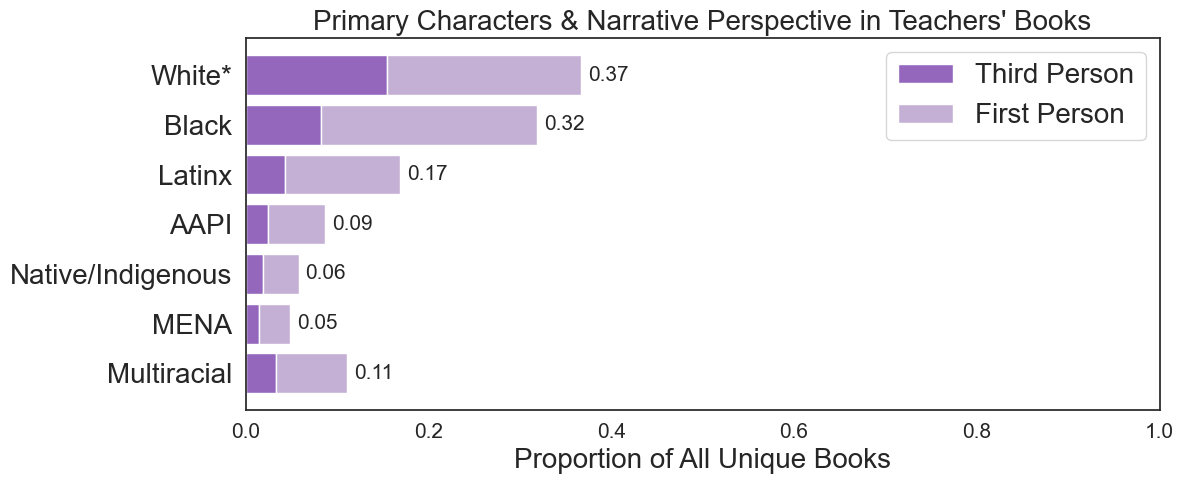

Backing off to first human protag: grendel - gardner


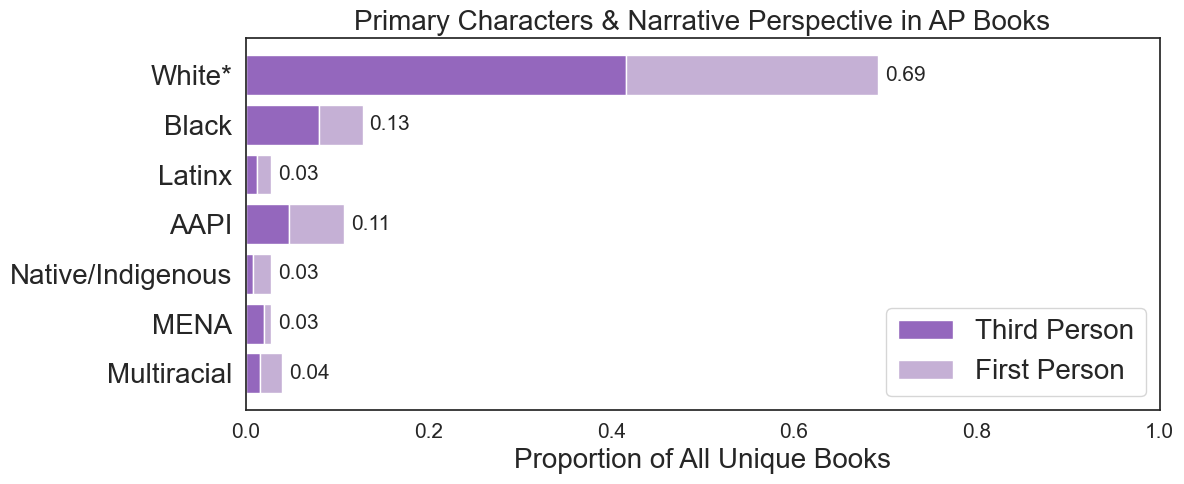

In [56]:
protag_info = {} # {combined_title: [main character race, pov]}
sns.set_theme(rc={'figure.figsize':(12, 5)})
sns.set_style("white")
for dataset in ['hollyhock', 'ap']: 
    main_char_counts = Counter()
    third_person = Counter()
    first_person = Counter()
    num_books = 0
    for title in book_chars: 
        if dataset == 'ap' and title not in ap_books: continue
        if dataset == 'hollyhock' and title not in hollyhock_books: continue
        protag = book_chars[title][0]
        if protag[1] == 'Non-human': 
            print("Backing off to first human protag:", title)
            protag = book_chars[title][1] 
        race = protag[1].lower()
        race = remap_race(race)
        main_char_counts.update(race)
        
        coref_IDs = protag[0].split('_')
        if '0' in coref_IDs: 
            first_person.update(race)
        else: 
            third_person.update(race)
        protag_info[title] = [race, '0' in coref_IDs]
        num_books += 1
    x1 = []
    x2 = []
    group_order = ['White*', 'Black', 'Latinx', 'AAPI', 'Native/Indigenous', 'MENA', 'Multiracial'][::-1]
    for k in group_order: 
        x1.append(third_person[k] / num_books)
        x2.append(first_person[k] / num_books)
    colors = iter([plt.cm.tab20(i) for i in range(20)])
    for i in range(8): next(colors)
    bottom = np.zeros(len(x1))
    plt.barh(group_order, x1, label='Third Person', color=[next(colors)])
    bottom += x1
    plt.barh(group_order, x2, label='First Person', left=bottom, color=[next(colors)])
    if dataset == 'hollyhock': 
        plt.title("Primary Characters & Narrative Perspective in Teachers' Books", fontsize=20)
    else: 
        plt.title("Primary Characters & Narrative Perspective in AP Books", fontsize=20)
    ax = plt.gca()
    ax.bar_label(ax.containers[-1], fmt='%.2f', fontsize=15, padding=5)
    plt.xlabel("Proportion of All Unique Books", fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

## AP Books' main characters over time

Figure 3 in the paper.

In [57]:
def plot_char_over_time(book_dict, plot_title): 
    x_nonwhite_protag = [] # fraction of total
    x_any_nonwhite = [] # fraction of total
    y = []
    d = {
        'Race/Ethnicity': [],
        'Count': [], 
        'Year': [], 
    }
    race_cats = ['White*', 'Black', 'Latinx', 'AAPI', 'Native/Indigenous', 'MENA']
    for year in range(min(book_dict.keys()), max(book_dict.keys()) + 1): 
        primary_count = 0
        secondary_count = 0
        race_counts = Counter()
        for title_author in book_dict[year]:
            contents = title_author.split(' | ')
            cleaned_title = clean_title(contents[0])
            author_lastname = get_last_name(contents[1], filter_multiple=False)
            if author_lastname is None: 
                print(cleaned_title)
                continue
            this_book_races = set()
            combined_title = cleaned_title  + ' - ' + author_lastname
            chars = book_chars[combined_title]
            for i, char in enumerate(chars): 
                race = char[1].lower()
                if race == 'n/a': continue
                race = remap_race(race)
                this_book_races.update(race)
                if 'White*' not in race: 
                    if i == 0: 
                        primary_count += 1
                    else: 
                        secondary_count += 1
                    break
            race_counts.update(this_book_races)
        total = len(book_dict[year])
        if total != 0: 
            x_nonwhite_protag.append(primary_count / total)
            x_any_nonwhite.append(secondary_count / total)
        else: 
            x_nonwhite_protag.append(0)
            x_any_nonwhite.append(0)
        y.append(year)
        for race in race_cats: 
            if total == 0: continue
            d['Race/Ethnicity'].append(race)
            d['Year'].append(year)
            d['Count'].append(race_counts[race]/ total)
            
    time_race_df = pd.DataFrame.from_dict(d)
    sns.set_theme(rc={'figure.figsize':(10, 5)})
    sns.set_style("whitegrid")
    sns.lineplot(data=time_race_df, x="Year", y="Count", hue='Race/Ethnicity', 
                 hue_order=race_cats, alpha=0.9, style='Race/Ethnicity', markers=True, dashes=False)
    plt.ylabel("Proportion of books", fontsize=20)
    plt.xlabel("Year", fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('AP Books w/ Main Characters in Racial/Ethnic Group', fontsize=20)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=20)
    plt.tight_layout()
    plt.show()
        
    colors = iter([plt.cm.tab20(i) for i in range(20)])
    sns.set_theme(rc={'figure.figsize':(10, 5)})
    sns.set_style("whitegrid")
    bottom = np.zeros(len(x_nonwhite_protag))
    first_color = next(colors)
    plt.bar(y, x_nonwhite_protag, label='Primary character', color=[first_color])
    plt.axhline(sum(x_nonwhite_protag) / (len(x_nonwhite_protag) - 1), linestyle = ':', color=first_color)
    bottom += x_nonwhite_protag
    second_color = next(colors)
    plt.bar(y, x_any_nonwhite, label='Only secondary character', bottom=bottom, color=[second_color])
    plt.axhline((sum(x_nonwhite_protag) + sum(x_any_nonwhite)) / (len(x_nonwhite_protag) - 1), linestyle = ':', color=second_color)
    plt.ylabel("Proportion of books", fontsize=20)
    plt.xlabel("Year", fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(0, 0.8)
    plt.title('AP Books with Main Characters of Color', fontsize=20)
    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=20)
    plt.show()

In [58]:
ap_year_narr_book = defaultdict(list)
with open('ap_by_year.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    for row in reader: 
        years = row['AP Exam Year/s']
        title_author = row['Title'] + ' | ' + row['Author']
        years = years.split(',')
        cleaned_title = clean_title(row['Title'])
        author_lastname = get_last_name(row['Author'], filter_multiple=False)
        assert author_lastname is not None 
        combined_title = cleaned_title  + ' - ' + author_lastname
        if combined_title not in ap_books: 
            # plays, poetry, etc
            continue 
        for y in years: 
            ap_year_narr_book[int(y)].append(title_author)

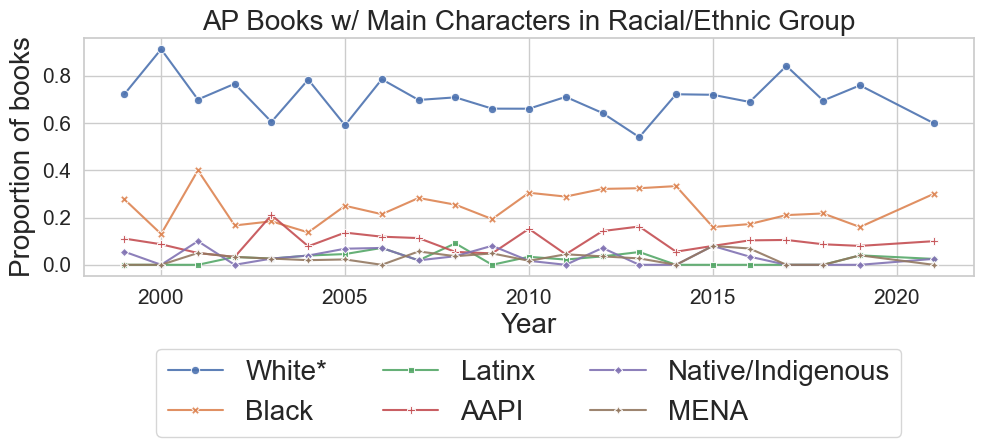

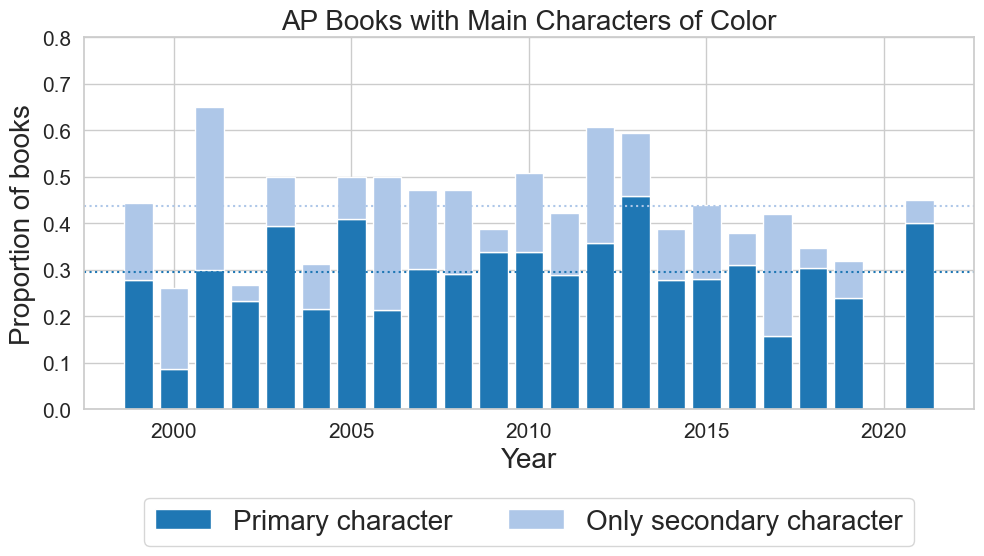

In [59]:
plot_char_over_time(ap_year_narr_book, "AP Literature")

## Hollyhock books' main characters

Figure 7 in the paper.

In [60]:
def plot_char_not_over_time(plot_title): 
    race_counts = defaultdict(Counter)
    gender_counts = Counter()
    seen_books = set()
    for combined_title in book_chars: 
        if plot_title == 'AP Literature' and combined_title not in ap_books: continue
        if plot_title == 'Hollyhock' and combined_title not in hollyhock_books: continue
        seen_books.add(combined_title)
        chars = book_chars[combined_title]
        primary_race = None
        this_book_races = set()
        this_book_genders = set()
        for i, char in enumerate(chars): 
            race = char[1].lower()
            if race == 'n/a': continue
            race = remap_race(race)
            this_book_races.update(race)
            if i == 0: 
                primary_race = race
            gender = book_genders[combined_title][i][1]
            this_book_genders.add(gender)
        gender_counts.update(this_book_genders)
        non_white_primary = False
        non_white_secondary = False
        for r in this_book_races: 
            if r == 'Non-human' or r == 'White': continue
            if r in primary_race: 
                race_counts['primary'][r] += 1
                if r != 'White*': 
                    non_white_primary = True
            else:
                race_counts['secondary'][r] += 1
                if r != 'White*': 
                    non_white_secondary = True
        if non_white_primary: 
            race_counts['primary']['All'] += 1
        elif non_white_secondary: 
            race_counts['secondary']['All'] += 1
    if plot_title == 'Hollyhock':
        assert seen_books == hollyhock_books
        total = len(hollyhock_books)
    elif plot_title == 'AP Literature': 
        assert seen_books == ap_books
        total = len(ap_books)
    
    colors = iter([plt.cm.tab20(i) for i in range(20)])
    sns.set_theme(rc={'figure.figsize':(10, 5)})
    sns.set_style("white")
    x_order = ['All', 'Black', 'Latinx', 'AAPI', 'Native/\nIndigenous', 'MENA', 'Multiracial']
    bottom = np.zeros(len(x_order))
    first_color = next(colors)
    primary_counts = []
    secondary_counts = []
    for r in x_order: 
        if r == 'Native/\nIndigenous': 
            r = 'Native/Indigenous'
        primary_counts.append(race_counts['primary'][r] / total)
        secondary_counts.append(race_counts['secondary'][r] / total)
    print(race_counts)
    print(gender_counts)
    
    plt.bar(x_order, primary_counts, label='Primary character', color=[first_color])
    bottom += primary_counts
    second_color = next(colors)
    plt.bar(x_order, secondary_counts, label='Only secondary character', bottom=bottom, color=[second_color])
    ax = plt.gca()
    ax.bar_label(ax.containers[-1], fmt='%.2f')
    plt.axvline(0.5, color='grey', linestyle = ':', alpha=0.5)
    plt.ylabel("Proportion of books", fontsize=20)
    plt.xlabel("Race/Ethnicity", fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(['All', 'Black', 'Latinx', 'AAPI', 'Native/\nIndigenous', 'MENA', 'Multiracial'], fontsize=15)
    plt.ylim(0, 1)
    if plot_title == 'Hollyhock':
        plt.title('Teachers\' Books with Main Characters of Color', fontsize=20)
    else: 
        plt.title('AP Books with Main Characters of Color', fontsize=20)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=20)
    plt.tight_layout()
    plt.show()

defaultdict(<class 'collections.Counter'>, {'secondary': Counter({'White*': 37, 'All': 14, 'Black': 12, 'Multiracial': 8, 'MENA': 4, 'Latinx': 3, 'AAPI': 2, 'Native/Indigenous': 1}), 'primary': Counter({'All': 131, 'White*': 76, 'Black': 66, 'Latinx': 35, 'Multiracial': 23, 'AAPI': 18, 'Native/Indigenous': 12, 'MENA': 10})})
Counter({'M': 192, 'F': 159, 'NB': 1, 'agender': 1})


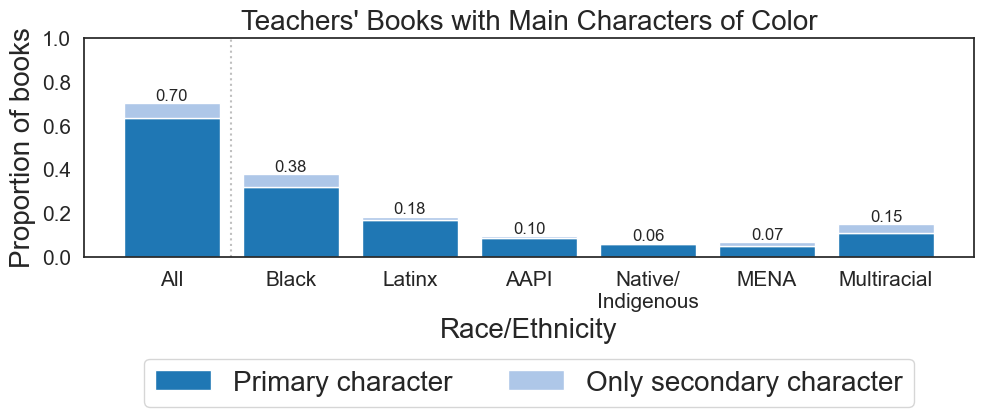

In [61]:
plot_char_not_over_time("Hollyhock")

## Author - Character Race

In [62]:
def get_author_race_gender(): 
    author_race = defaultdict(list)
    author_gender = defaultdict(str)
    num_lines = 0
    with open('author_list.csv', 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            author = row['Author']
            if author.strip() == '': continue
            num_lines += 1
            race = []
            for item in row['Race/Ethnicity'].split(','): 
                label = item.strip().lower()
                if label == 'asian' or label == 'pacific islander': 
                    label = 'aapi'
                race.append(label)
            author_gender[author] = row['Gender']
            author_race[author] = race
    return author_race, author_gender

In [63]:
author_race, author_gender = get_author_race_gender()

In [64]:
def is_poc(race): 
    if len(race) == 1 and (race[0] == 'white' or race[0] == 'n/a'): 
        return False
    return True

def get_book_author_poc(): 
    book_author_poc = {}
    book_author_race = {}
    book_author_gender = {}
    with open('book_lists.csv', 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            cleaned_title = clean_title(row['Title'])
            author_lastname = get_last_name(row['Author/s'], filter_multiple=False)
            assert author_lastname is not None 
            combined_title = cleaned_title  + ' - ' + author_lastname

            # Author race
            author = row['Author/s']
            if author not in author_race: 
                authors = author.split(', ')
            else: 
                authors = [author]
            author_poc = False
            author_races = set()
            author_genders = set()
            for author in authors: 
                race = author_race[author]
                remapped_race = remap_race(', '.join(race))
                author_races.update(remapped_race)
                if is_poc(race): 
                    author_poc = True
                author_genders.update(author_gender[author])
            book_author_poc[combined_title] = author_poc
            book_author_race[combined_title] = author_races
            book_author_gender[combined_title] = author_genders
    return book_author_poc, book_author_race, book_author_gender
book_author_poc, book_author_race, book_author_gender = get_book_author_poc()

In [65]:
books_to_race_comp = defaultdict(dict) # {combined_title: {main characters of color boolean, 
                    # first person primary character of color boolean, 
                    # third person primary character of color boolean, 
                    # white and non-white main characters boolean}}
for combined_title in book_chars: 
    if not book_chars[combined_title]: print(combined_title)
    protag = book_chars[combined_title][0]
    if combined_title == 'grendel - gardner': 
        # primary character is non-human
        protag = book_chars[combined_title][1] 
    protag_corefIDs = protag[0].split('_')
    protag_race = protag[1].lower()
    protag_race = remap_race(protag_race)
    if protag_race[0] == 'White*': 
        books_to_race_comp[combined_title]['first person primary character of color'] = False
        books_to_race_comp[combined_title]['third person primary character of color'] = False
    else: 
        if '0' in protag_corefIDs: 
            books_to_race_comp[combined_title]['first person primary character of color'] = True
            books_to_race_comp[combined_title]['third person primary character of color'] = False
        else: 
            books_to_race_comp[combined_title]['first person primary character of color'] = False
            books_to_race_comp[combined_title]['third person primary character of color'] = True
        
    has_white = False
    books_to_race_comp[combined_title]['main characters of color'] = False
    for char in book_chars[combined_title]: 
        char_corefIDs = char[0].split('_')
        if char[1].lower() == 'n/a': 
            print("MISSING:", combined_title, char) 
            print()
            continue
        char_race = remap_race(char[1].lower().strip())
        if 'White*' not in char_race and 'Non-human' not in char_race: 
            books_to_race_comp[combined_title]['main characters of color'] = True
        elif 'White*' in char_race: 
            has_white = True
    books_to_race_comp[combined_title]['white and non-white main characters'] = books_to_race_comp[combined_title]['main characters of color'] and has_white

First person poc, white author: thus spoke zarathustra - nietzsche
First person poc, white author: sold - mccormick
First person poc, white author: life of pi - martel


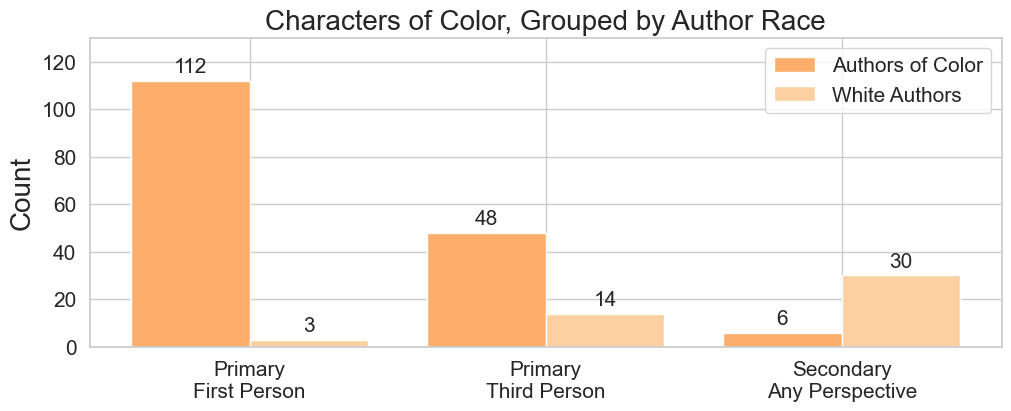

In [68]:
xlabels = ['Primary\nFirst Person', 'Primary\nThird Person', 'Secondary\nAny Perspective']
char_type_counts = {
    'white authors': [0, 0, 0],
    'non-white authors': [0, 0, 0]
}

for combined_title in books_to_race_comp: 
    if not books_to_race_comp[combined_title]['main characters of color']: continue
    if book_author_poc[combined_title]: 
        if books_to_race_comp[combined_title]['first person primary character of color']: 
            char_type_counts['non-white authors'][0] += 1
        elif books_to_race_comp[combined_title]['third person primary character of color']: 
            char_type_counts['non-white authors'][1] += 1
        else: 
            char_type_counts['non-white authors'][2] += 1
    else: 
        if books_to_race_comp[combined_title]['first person primary character of color']: 
            print("First person poc, white author:", combined_title)
            char_type_counts['white authors'][0] += 1
        elif books_to_race_comp[combined_title]['third person primary character of color']: 
            char_type_counts['white authors'][1] += 1
        else: 
            char_type_counts['white authors'][2] += 1
            
x = np.arange(len(xlabels))  # the label locations

sns.set_style("whitegrid")
fig, ax = plt.subplots(layout='constrained', figsize=(10, 4))

colors = iter([plt.cm.tab20c(i) for i in range(20)])
for i in range(6): next(colors)
rects = ax.bar(x - 0.2, char_type_counts['non-white authors'], 0.4, label='Authors of Color', color=next(colors))
ax.bar_label(rects, padding=3, fontsize=15)
rects = ax.bar(x + 0.2, char_type_counts['white authors'], 0.4, label='White Authors', color=next(colors))
ax.bar_label(rects, padding=3, fontsize=15)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Characters of Color, Grouped by Author Race', fontsize=20)
ax.set_xticks(x, xlabels, fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(loc='upper right', fontsize=15)
ax.set_ylim(0, 130)

plt.show()

In [69]:
d = {
    'combined_title': [], 
    'Author race': [],
    'Character race': [],
    'matches': [], # whether author and character race overlaps
    'burstiness': [],
    'mentions': [],
    'Dataset': [],
    'character type': [],
}
for combined_title in book_chars:
    for i, char in enumerate(book_chars[combined_title]): 
        char_race = char[1].lower().strip()
        char_corefIDs = char[0]
        char_race = remap_race(char_race)
        if 'Non-human' in char_race: continue
        
        author_race = book_author_race[combined_title]
        if not set(char_race) & set(author_race): 
            d['matches'].append(False)
        else: 
            d['matches'].append(True)
        
        burstiness = all_burstiness_score[combined_title][char]
        total = sum(all_mention_counter[combined_title].values())
        mentions = all_mention_counter[combined_title][char] / total
        if i == 0:
            d['character type'].append('primary')
        else:
            d['character type'].append('secondary')
        d['burstiness'].append(burstiness)
        d['mentions'].append(mentions)
        d['combined_title'].append(combined_title)
        if char_race[0] == 'White*': 
            d['Character race'].append('white character')
        elif 'non-human' not in char_race:
            d['Character race'].append('character of color')
        if book_author_poc[combined_title]: 
            d['Author race'].append('Non-white')
        else: 
            d['Author race'].append('White')
            
        if combined_title in ap_books and combined_title in hollyhock_books: 
            d['Dataset'].append('Both')
        elif combined_title in ap_books: 
            d['Dataset'].append('AP Lit Only')
        elif combined_title in hollyhock_books: 
            d['Dataset'].append('Hollyhock Only')
df3 = pd.DataFrame.from_dict(d)
df3

,combined_title,Author race,Character race,matches,burstiness,mentions,Dataset,character type
0,zeitoun - eggers,White,white character,True,0.633080,0.516298,Hollyhock Only,primary
1,zeitoun - eggers,White,character of color,False,0.274782,0.253020,Hollyhock Only,secondary
2,zeitoun - eggers,White,character of color,False,0.827348,0.147709,Hollyhock Only,secondary
3,zeitoun - eggers,White,character of color,False,0.656669,0.082972,Hollyhock Only,secondary
4,yellow raft in blue water - dorris,Non-white,character of color,True,0.689370,0.408643,AP Lit Only,primary
...,...,...,...,...,...,...,...,...
1579,57 bus - slater,White,character of color,False,0.595805,0.528867,Hollyhock Only,primary
1580,57 bus - slater,White,white character,True,0.662089,0.324074,Hollyhock Only,secondary
1581,57 bus - slater,White,character of color,False,0.597959,0.147059,Hollyhock Only,secondary
1582,12 years a slave - northup,Non-white,character of color,True,0.420326,0.859421,Hollyhock Only,primary


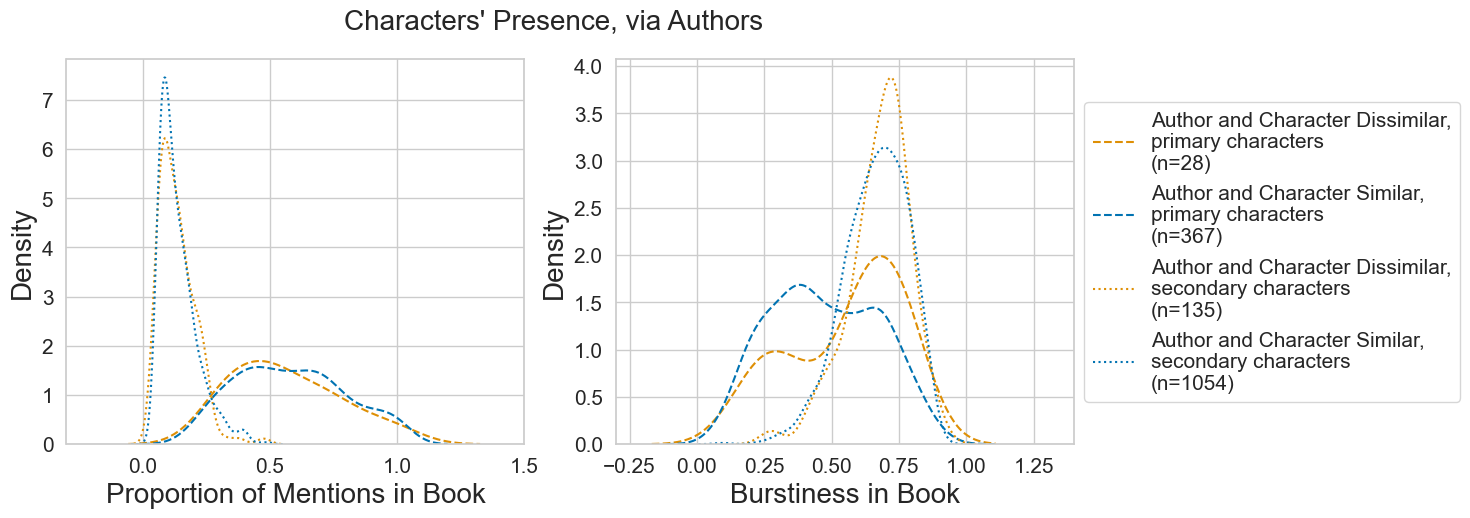

In [72]:
sns.set(rc={'figure.figsize':(13, 5)})
colors = sns.color_palette("colorblind")
sns.set_style("whitegrid")
_, axs = plt.subplots(1, 2)
primary_df = df3[df3['character type'] == 'primary']
sns.kdeplot(data=primary_df, x="mentions", hue="matches", 
            common_norm=False, hue_order=[True, False], 
            linestyle="--", ax=axs[0], palette=colors[:2])
secondary_df = df3[df3['character type'] == 'secondary']
sns.kdeplot(data=secondary_df, x="mentions", hue="matches", 
            common_norm=False, hue_order=[True, False],
           linestyle=":", ax=axs[0], palette=colors[:2])
axs[0].get_legend().remove()
axs[0].set_xlabel("Proportion of Mentions in Book", fontsize=20)
axs[0].set_ylabel("Density", fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].set_xlim(-0.3, 1.5)

primary_df = df3[df3['character type'] == 'primary']
match_primary_count = len(primary_df[primary_df['matches'] == True])
nomatch_primary_count = len(primary_df[primary_df['matches'] == False])
ax1 = sns.kdeplot(data=primary_df, x="burstiness", hue="matches", 
            common_norm=False, hue_order=[True, False], 
            linestyle="--", legend=False, ax=axs[1], palette=colors[:2])
secondary_df = df3[df3['character type'] == 'secondary']
match_secondary_count = len(secondary_df[secondary_df['matches'] == True])
nomatch_secondary_count = len(secondary_df[secondary_df['matches'] == False])
sns.kdeplot(data=secondary_df, x="burstiness", hue="matches", 
            common_norm=False, hue_order=[True, False],
           linestyle=":", legend=False, ax=axs[1], palette=colors[:2])
plt.legend(['Author and Character Dissimilar,\nprimary characters\n(n=' + str(nomatch_primary_count) + ')', 
            'Author and Character Similar,\nprimary characters\n(n=' + str(match_primary_count) + ')', 
            'Author and Character Dissimilar,\nsecondary characters\n(n=' + str(nomatch_secondary_count) + ')',
            'Author and Character Similar,\nsecondary characters\n(n=' + str(match_secondary_count) + ')'], loc='center left', 
           bbox_to_anchor=(1, 0.5), fontsize=15)
axs[1].set_xlabel("Burstiness in Book", fontsize=20)
axs[1].set_xlim(-0.3, 1.4)
axs[1].set_ylabel("Density", fontsize=20)
axs[1].tick_params(axis='both', labelsize=15)
plt.suptitle("Characters' Presence, via Authors", fontsize=20)
plt.show()